# fastText on Legal Question
raoxi@jurtech.xyz

In [2]:
import numpy as np
np.random.seed(1337)
import sqlite3
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.datasets import imdb
from jieba import cut, lcut, lcut_for_search
import pickle
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [11]:
conn = sqlite3.connect('fastLQ.db')
cur = conn.execute('select * from question ORDER BY RANDOM()').fetchall()
len(cur)

100000

In [12]:
tag = conn.execute('select  type from question group by type').fetchall()

In [13]:
len(tag)

68

In [14]:
tag[1][0]

'交通事故'

In [25]:
word_list=[]
for each in cur:
    cutted = lcut(each[1])
    word_list.extend(cutted)
word_list = list(set(word_list))
len(word_list)

53999

In [26]:
cur[2][1]

'发生交通事故受害人死亡，按照法律上是怎么处理。'

In [27]:
cur[2][2]

'交通事故'

In [15]:
f1 = open('fate_lq_word_list.pkl', 'wb')
pickle.dump(word_list,f1)

In [28]:
word2int ={}
for i in range(len(word_list)):
    word2int[word_list[i]] = i
len(word2int)

53999

In [34]:
def text2int(token_set):
    return [word2int.get(x,0) for x in token_set]

In [35]:
label_dict = {}
for i in range(len(tag)):
    label_dict[tag[i][0]] = i

In [36]:
def case_to_X_Y(content,label):
    content_split = lcut(content)
    X = text2int(content_split)
    Y = label_dict.get(label)
    return X, Y

In [37]:
data_x_y = []
for each in cur:
    content =  each[1]
    label =  each[2]
    try:
        x_ , y_ = case_to_X_Y(content,label)
    except:
        continue
    data_x_y.append((x_,y_))
print(len(data_x_y))

100000


In [38]:
CLASS_TYPE =len(tag)
def pre_process_y(y):
    y_  = np.array(y)
    y_ = to_categorical(y_,num_classes=CLASS_TYPE)
    return y_

In [39]:
SAMPLE_SIZE =80000
# DATASET
len(data_x_y)
data_dev = data_x_y[:SAMPLE_SIZE]
data_test = data_x_y[SAMPLE_SIZE:]
x_dev = [i[0] for i in data_dev]
y_dev = [i[1] for i in data_dev]
x_test = [i[0] for i in data_test]
y_test = [i[1] for i in data_test]

In [40]:
max_features = len(word_list)
maxlen = 128
batch_size = 32
embedding_dims = 64

In [41]:
x_dev = sequence.pad_sequences(x_dev, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
y_dev = pre_process_y(y_dev)
y_test = pre_process_y(y_test)

In [42]:
cur[1111][2]

'婚姻家庭'

In [43]:
y_dev[1111]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [45]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dims))
model.add(GlobalAveragePooling1D())
model.add(Dense(CLASS_TYPE, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          3455936   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 68)                4420      
Total params: 3,460,356
Trainable params: 3,460,356
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(x_dev, y_dev,
          batch_size=batch_size,
          validation_data=(x_test, y_test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 149s - loss: 2.8060 - acc: 0.2231 - val_loss: 2.5580 - val_acc: 0.3438
Epoch 2/10
80000/80000 [==============================] - 147s - loss: 2.2513 - acc: 0.4450 - val_loss: 2.0458 - val_acc: 0.5160
Epoch 3/10
80000/80000 [==============================] - 145s - loss: 1.8078 - acc: 0.5676 - val_loss: 1.7131 - val_acc: 0.5821
Epoch 4/10
80000/80000 [==============================] - 156s - loss: 1.5196 - acc: 0.6305 - val_loss: 1.5022 - val_acc: 0.6280
Epoch 5/10
80000/80000 [==============================] - 150s - loss: 1.3228 - acc: 0.6755 - val_loss: 1.3607 - val_acc: 0.6656
Epoch 6/10
80000/80000 [==============================] - 150s - loss: 1.1783 - acc: 0.7098 - val_loss: 1.2587 - val_acc: 0.6854
Epoch 7/10
80000/80000 [==============================] - 157s - loss: 1.0632 - acc: 0.7374 - val_loss: 1.1791 - val_acc: 0.7014
Epoch 8/10
80000/80000 [=======================

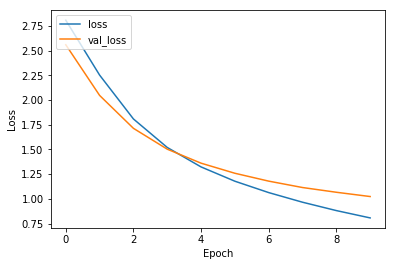

In [47]:
# summarize loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

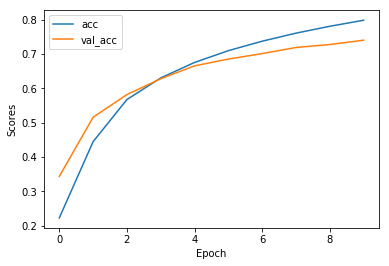

In [48]:
# summarize loss and accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Scores')
plt.xlabel('Epoch')
plt.legend([ 'acc','val_acc'], loc='upper left')
plt.show()

In [88]:
def test_case(text):
    cutted= lcut(text)
    X = text2int(cutted)
    Y = model.predict(np.array([X]))
    Y =np.argmax(Y[0])
    for k,v in label_dict.items():
        if v == Y:
            print("C: "+k)

In [89]:
text1='''面试谈工资的时候，对方问你的期望薪资，如果反问对方「根据自己的能力能给多少」，合适吗？
'''
test_case(text1)

C: 劳动纠纷


In [63]:
text2='''虚开增值税专用发票是怎么谋利的？
'''
test_case(text1)

劳动纠纷


In [64]:
text3='''朋友欠我145万，不还怎么办？
'''
test_case(text3)

债权债务


In [65]:
text4='''如何看待北京德勤癌症员工离职纠纷？
'''
test_case(text4)

劳动纠纷


In [66]:
text5='''我怀孕了，但他离不了婚，怎么办？
'''
test_case(text5)

婚姻家庭


In [67]:
text6='''老婆脾气暴不懂事，经常吵架，现在有孩子了又不能离婚，很痛苦怎么办？
'''
test_case(text6)

婚姻家庭


In [68]:
text7='''公司注册资本多少是什么概念？
'''
test_case(text7)

公司犯罪


In [69]:
text8='''农村自建房的土地使用证可以过户吗？程序如何？
'''
test_case(text8)

土地纠纷


In [70]:
text9='''如何利用法院强制执行来追讨债务？
'''
test_case(text9)

债权债务


In [71]:
text10='''开发商破产，我已经弃房断供了两年了，现在该怎么办？
'''
test_case(text10)

房产纠纷


In [72]:
text11='''鸦片、大麻、海洛因、冰毒的区别是什么？
'''
test_case(text11)

刑事辩护
